## Dev

In [ ]:
%pip install -qU langchain-community langgraph langgraph-checkpoint-sqlite langchain-openai langchain-groq langchain_mistralai

### LangGraph

In [1]:
from typing import Annotated, Literal, Sequence, List, Any, Dict
from typing_extensions import TypedDict
from pprint import pprint

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.callbacks.base import BaseCallbackHandler

from pydantic import BaseModel, Field

import sys
sys.path.insert(1, '../DefAgent')

import src.prompts as prompts
import src.utils as utils
import src.tools as tools
import src.models as models
import src.retriever as retriever

ModuleNotFoundError: No module named 'src.prompts'

In [ ]:
class CustomHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        formatted_prompts = "\n".join(prompts)
        print(f"-> PROMPT:\n{formatted_prompts}\n")


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    input_query: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


class DefAgent:
    def __init__(self, model):
        self.model = model
        self.vectorstore = retriever.setup_vectorstore()
        self.retriever_tool = tools.create_vector_search_tool(self.vectorstore)
        self.tools = [self.retriever_tool]
        self.workflow = self.setup_workflow()

    def agent(self, state):
        """
        Invokes the agent model to generate a response based on the current state. Given
        the question, it will decide to retrieve using the retriever tool, or simply end.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        print("---QURY AGENT---")
        model = self.model.bind_tools(self.tools)
        input_query = state["input_query"]
        messages = state["messages"]
        response = model.invoke(messages, config={"callbacks": [CustomHandler()]})
        return {"messages": [response], "input_query": input_query}
    

    def filter_definitions(self, state) -> Literal["generate"]:
        """
        Filters the retrieved definitions based on their relevance to the question.

        Args:
            state (messages): The current state

        Returns:
            List[dict]: A list of dictionaries containing the relevant definitions and their metadata.
        """

        print("---FILTER DEFINITIONS---")

        class DefinitionMetadata(BaseModel):
            id: int = Field(description="the unique identifier of the definition")
            dataset: str = Field(description="the dataset the definition is from")
            document_id: str = Field(description="the document id the definition is from")
            references: List[str] = Field(description="the references mentioned the definition.")

        class Definition(BaseModel):
            metadata: DefinitionMetadata
            definition_text: str = Field(description="the full text of the definition")  # Changed from 'definition'

        class DefinitionsList(BaseModel):
            relevant_definitions: List[Definition] = Field(description="a list of relevant definitions")

        parser = PydanticOutputParser(pydantic_object=DefinitionsList)

        prompt = PromptTemplate(
            template="""
            You are a legal expert assessing the relevance of legal definitions to a user question. \n 
            Your job is to filter the list of definitions provided to you keeping only the relevant ones. \n
            If the definition contains keyword(s) or semantic meaning related to the user's question, keep it.\n
            Output only the relevant definitions using the formatting instructions provided. \n
            Here are the formatting instructions: {format_instructions} \n
            Here are the retrieved definitions, one for each line: \n {context} \n
            Here is the user question: {question} \n
            """,
            input_variables=["context", "question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        chain = prompt | self.model

        messages = state["messages"]
        last_message = messages[-1]

        question = state["input_query"]
        docs = last_message.content

        response = chain.invoke({"question": question, "context": docs}, config={"callbacks": [CustomHandler()]})

        return {"messages": [response]}


    def generate(self, state):
        """
        Generate definition

        Args:
            state (messages): The current state

        Returns:
            str: A legal definition
        """
        print("---GENERATE---")
        messages = state["messages"]
        question = state["input_query"]
        last_message = messages[-1]

        docs = last_message.content

        prompt = PromptTemplate(
            template="""
            You are a legal assistant for the task of generating legal definitions. \n
            Use the following retrieved definitions as context to answer the question. \n
            If you don't know the answer, just say that you don't know. \n
            Keep the answer concise and straight to the point, giving only the definition.
            Question: {question} \n
            Context: {context} \n
            Answer:
            """,
            input_variables=["context", "question"]
        )

        llm = self.model

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        rag_chain = prompt | llm | StrOutputParser()

        response = rag_chain.invoke({"context": docs, "question": question}, config={"callbacks": [CustomHandler()]})
        return {"messages": [response]}
    

    def eurlex_agent(self, state):
        raise NotImplementedError

    def normattiva_agent(self, state):
        raise NotImplementedError

    def pdl_agent(self, state):
        raise NotImplementedError

    def setup_workflow(self):
        workflow = StateGraph(AgentState)

        workflow.add_node("agent", self.agent)  # agent
        workflow.add_node("retrieve", ToolNode([self.retriever_tool]))  # retrieval
        workflow.add_node("filter", self.filter_definitions)  # retrieval
        workflow.add_node("generate", self.generate)  # Generating a response after we know the documents are relevant
        #workflow.add_node("RefResolver", self.resolve_references)
        #workflow.add_node("EurLex agent", self.eurlex_agent)
        #workflow.add_node("Normattiva agent", self.normattiva_agent)
        #workflow.add_node("PDL agent", self.pdl_agent)


        workflow.add_edge(START, "agent")

        # Decide whether to retrieve
        workflow.add_conditional_edges(
            "agent",
            # Assess agent decision
            tools_condition,
            {
                # Translate the condition outputs to nodes in our graph
                "tools": "retrieve",
                END: END,
            },
        )

        workflow.add_edge("retrieve", "filter")
        #workflow.add_edge("filter", "RefResolver")
        workflow.add_edge("filter", "generate")
        #workflow.add_edge("generate", "EurLex agent")
        #workflow.add_edge("generate", "Normattiva agent")
        #workflow.add_edge("generate", "PDL agent")
        #workflow.add_edge("EurLex agent", END)
        #workflow.add_edge("Normattiva agent", END)
        #workflow.add_edge("PDL agent", END)
        workflow.add_edge("generate", END)

        self.graph = workflow.compile()

        return workflow
    
    def invoke(self, query):
        inputs = {
            "input_query": query,
            "messages": [
                ("system", ''),
                ("user", query),
            ]
        }

        for output in self.graph.stream(inputs):
            for key, value in output.items():
                print(f"<- OUTPUT from node '{key}':\n")
                print(value['messages'][-1])#, indent=2, width=80, depth=None)
            print("\n---\n")

model = models.groq
defagent = DefAgent(model)

---

## Use

In [ ]:
output_nodes = ['model', 'answer']
graph.nodes.keys() - output_nodes

['__start__',
 'eurlex_agent',
 'extract_definendum',
 'filter_definitions',
 'generate_definition',
 'normattiva_agent',
 'pdl_agent',
 'pick_definition',
 'query_vectorstore',
 'task_manager']

TypeError: unsupported operand type(s) for -: 'list' and 'list'

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

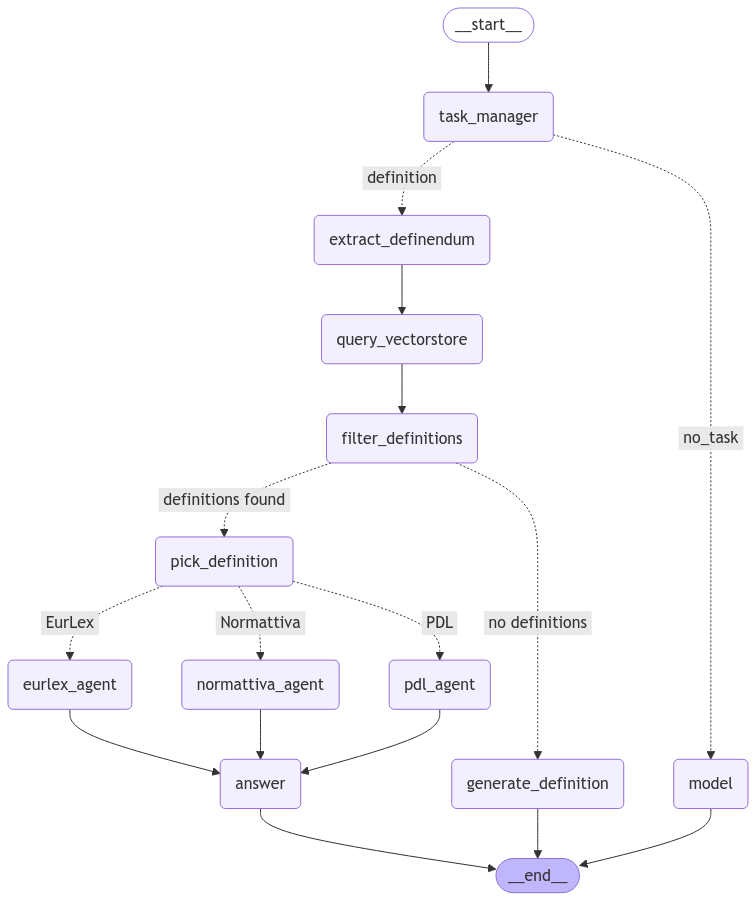

In [1]:
from LegalDefAgent.src.agent import LegalDefAgent
from LegalDefAgent.src.llm import get_model
from LegalDefAgent.src import utils

groq = get_model('groq-llama3-70b-8192')
defagent = LegalDefAgent(model=groq)

graph = defagent.graph_runnable

utils.draw_graph(graph)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

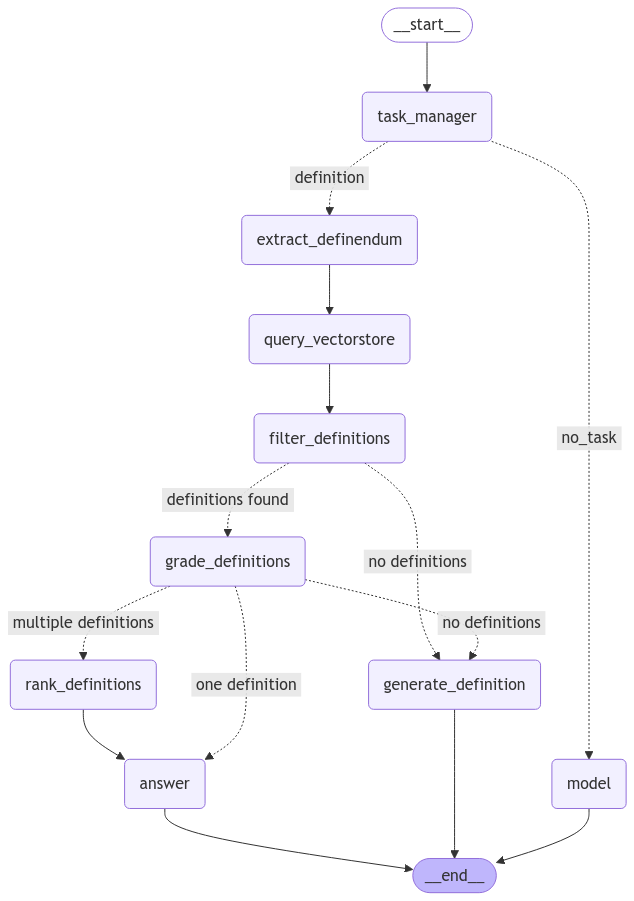

In [1]:
from LegalDefAgent.src.agent2 import LegalDefAgent
from LegalDefAgent.src.llm import get_model
from LegalDefAgent.src import utils

groq = get_model('groq-llama3-70b-8192')
defagent = LegalDefAgent(model=groq)

graph = defagent.graph_runnable

utils.draw_graph(graph)

---

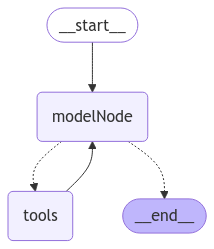

Thread ID: 123

Closing the conversation.


In [ ]:
from typing import Annotated, TypedDict, Literal

from langchain_core.messages import BaseMessage, AIMessage, SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, StructuredTool
from langgraph.graph import START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_openai import ChatOpenAI

from LegalDefAgent.src.llm import _get_model
from LegalDefAgent.src import utils

# Define a search tool using DuckDuckGo API wrapper
search_DDG = StructuredTool.from_function(
        name="Search",
        func=DuckDuckGoSearchAPIWrapper().run,  # Executes DuckDuckGo search using the provided query
        description=f"""
        useful for when you need to answer questions about current events. You should ask targeted questions
        """,
    )


@tool
def definitions_agent():
    """A tool that generates definitions of terms."""

    return "The definition is 43 and it should be spelled in French"

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    # A simplified weather response based on location
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def get_coolest_cities():
    """Get a list of coolest cities."""
    # Hardcoded response with a list of cool cities
    return "nyc, sf"

from LegalDefAgent.src.tools import extract_definition_from_xmldb


# List of tools that will be accessible to the graph via the ToolNode
tools = [get_weather, get_coolest_cities, search_DDG, definitions_agent]

# This is the default state same as "MessageState" TypedDict but allows us accessibility to custom keys
class GraphsState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # Custom keys for additional data can be added here such as - conversation_id: str

graph = StateGraph(GraphsState)

## Function to decide whether to continue tool usage or end the process
#def should_continue(state: GraphsState) -> Literal["tools", "__end__"]:
    #messages = state["messages"]
    #last_message = messages[-1]
    #if last_message.tool_calls:  # Check if the last message has any tool calls
        #return "tools"  # Continue to tool execution
    #return "__end__"  # End the conversation if no tool is needed

# Core invocation of the model
def _call_model(state: GraphsState):
    messages = state["messages"]
    llm = _get_model('groq_tool', streaming=False).bind_tools(tools, parallel_tool_calls=False)
    response = llm.invoke(messages)
    return {"messages": [response]}  # add the response to the messages using LangGraph reducer paradigm

# Define the structure (nodes and directional edges between nodes) of the graph
tools = [extract_definition_from_xmldb]
tool_node = ToolNode(tools)

graph.add_node("modelNode", _call_model)
graph.add_node("tools", tool_node)

# Add conditional logic to determine the next step based on the state (to continue or to end)
graph.add_edge(START, "modelNode")
graph.add_conditional_edges(
    "modelNode",
    tools_condition,  # This function will decide the flow of execution
)
graph.add_edge("tools", "modelNode")

# Compile the state graph into a runnable object
graph_runnable = graph.compile()

def invoke(runnable, config=None) -> None:
    """
    Invoke the agent with a user's question.
    Args:
        question (str): The user's question
        config (optional): Additional configuration
    """
    inputs = {
        "input": question,
        "messages": [
            HumanMessage(content=question)
        ]
    }

    thread_id = config.get("configurable", None).get("thread_id")
    if thread_id is None:
        thread_id = uuid.uuid4()
    print(f"Thread ID: {thread_id}")

    config = {
        "configurable": {
            "thread_id": thread_id,
        }
    }

    _printed = set()
    while True:
        user = input("User (q/Q to quit): ")# if not question else question
        if user in {"q", "Q"}:
            print("\nClosing the conversation.")
            break
        output = None
        for output in runnable.stream(
            {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="values"
        ):
            utils._print_event(output, _printed)

utils.draw_graph(graph_runnable)
invoke(graph_runnable, config={"configurable": {"thread_id": "123"}})

In [10]:
from langchain.globals import set_debug, set_verbose

set_debug(False)
set_verbose(False)

config = {
    "configurable": {
        "thread_id": "test",
    }
}
question = "What is the definition of a contract?"

defagent.ainvoke(question=question, config=config)

AttributeError: 'LegalDefAgent' object has no attribute 'ainvoke'

In [74]:
t1 = "{\"relevant_definitions\": [{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 8160, \"dataset\": \"EurLex\", \"document_id\": \"32013R0813.xml\", \"def_n\": \"#def_4\", \"references\": []}}, {\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 1231, \"dataset\": \"EurLex\", \"document_id\": \"32013R0811.xml\", \"def_n\": \"#def_4\", \"references\": []}}, {\"definition_text\": \"heat pump water heater: means a water heater using ambient heat from an air source, water source or ground source, and/or waste heat for heat generation;\", \"metadata\": {\"id\": 5425, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_10\", \"references\": []}}, {\"definition_text\": \"water catchment: means an area or basin of land bounded by natural features such as hills or mountains, into which all run–off water flows;\", \"metadata\": {\"id\": 1489, \"dataset\": \"EurLex\", \"document_id\": \"32016R0429.xml\", \"def_n\": \"#def_36\", \"references\": []}},\n{\"definition_text\": \"heat pump water heater: means a water heater that uses ambient heat from an air source, water source or ground source, and/or waste heat for heat generation.\", \"metadata\": {\"id\": 2306, \"dataset\": \"EurLex\", \"document_id\": \"32013R0812.xml\", \"def_n\": \"#def_13\", \"references\": []}}, {\"definition_text\": \"water supplier: means an entity supplying water intended for human consumption;\", \"metadata\": {\"id\": 987, \"dataset\": \"EurLex\", \"document_id\": \"32020L2184.xml\", \"def_n\": \"#def_3\", \"references\": []}, {\"definition_text\": \"water heater: means a device that is connected to an external supply of drinking or sanitary water; generates and transfers heat to deliver drinking or sanitary hot water at given temperature levels, quantities and flow rates during given intervals; and is equipped with one or more heat generators;\", \"metadata\": {\"id\": 5416, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_1\", \"references\": []}}]}"
t2 = "{\"relevant_definitions\": [{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 8160, \"dataset\": \"EurLex\", \"document_id\": \"32013R0813.xml\", \"def_n\": \"#def_4\", \"references\": []}}, {\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 1231, \"dataset\": \"EurLex\", \"document_id\": \"32013R0811.xml\", \"def_n\": \"#def_4\", \"references\": []}}, {\"definition_text\": \"water catchment: means an area or basin of land bounded by natural features such as hills or mountains, into which all run–off water flows;\", \"metadata\": {\"id\": 1489, \"dataset\": \"EurLex\", \"document_id\": \"32016R0429.xml\", \"def_n\": \"#def_36\", \"references\": []}}, {\"definition_text\": \"water supplier: means an entity supplying water intended for human consumption;\", \"metadata\": {\"id\": 987, \"dataset\": \"EurLex\", \"document_id\": \"32020L2184.xml\", \"def_n\": \"#def_3\", \"references\": []}}, {\"definition_text\": \"water heater: means a device that is connected to an external supply of drinking or sanitary water; generates and transfers heat to deliver drinking or sanitary hot water at given temperature levels, quantities and flow rates during given intervals; and is equipped with one or more heat generators;\", \"metadata\": {\"id\": 5416, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_1\", \"references\": []}}, {\"definition_text\": \"heat pump water heater: means a water heater using ambient heat from an air source, water source or ground source, and/or waste heat for heat generation;\", \"metadata\": {\"id\": 5425, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_10\", \"references\": []}}, {\"definition_text\": \"heat pump water heater: means a water heater that uses ambient heat from an air source, water source or ground source, and/or waste heat for heat generation.\", \"metadata\": {\"id\": 2306, \"dataset\": \"EurLex\", \"document_id\": \"32013R0812.xml\", \"def_n\": \"#def_13\", \"references\": []}}]}"
t3 = "{\"relevant_definitions\": [\n{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 8160, \"dataset\": \"EurLex\", \"document_id\": \"32013R0813.xml\", \"def_n\": \"#def_4\", \"references\": []}},\n{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 1231, \"dataset\": \"EurLex\", \"document_id\": \"32013R0811.xml\", \"def_n\": \"#def_4\", \"references\": []}},\n{\"definition_text\": \"heat pump water heater: means a water heater using ambient heat from an air source, water source or ground source, and/or waste heat for heat generation;\", \"metadata\": {\"id\": 5425, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_10\", \"references\": []}},\n{\"definition_text\": \"water catchment: means an area or basin of land bounded by natural features such as hills or mountains, into which all run–off water flows;\", \"metadata\": {\"id\": 1489, \"dataset\": \"EurLex\", \"document_id\": \"32016R0429.xml\", \"def_n\": \"#def_36\", \"references\": []}},\n{\"definition_text\": \"heat pump water heater: means a water heater that uses ambient heat from an air source, water source or ground source, and/or waste heat for heat generation.\", \"metadata\": {\"id\": 2306, \"dataset\": \"EurLex\", \"document_id\": \"32013R0812.xml\", \"def_n\": \"#def_13\", \"references\": []}},\n{\"definition_text\": \"water supplier: means an entity supplying water intended for human consumption;\", \"metadata\": {\"id\": 987, \"dataset\": \"EurLex\", \"document_id\": \"32020L2184.xml\", \"def_n\": \"#def_3\", \"references\": []}},\n{\"definition_text\": \"water heater: means a device that is connected to an external supply of drinking or sanitary water; generates and transfers heat to deliver drinking or sanitary hot water at given temperature levels, quantities and flow rates during given intervals; and is equipped with one or more heat generators;\", \"metadata\": {\"id\": 5416, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_1\", \"references\": []}}\n]}"

parser.parse(t1)

In [27]:
print(repr(t1.replace('\n', "")))
print()

'{"relevant_definitions": [{"definition_text": "water-based central heating system: or parts thereof;", "metadata": {"id": 8160, "dataset": "EurLex", "document_id": "32013R0813.xml", "def_n": "#def_4", "references": []}},{"definition_text": "water-based central heating system: or parts thereof;", "metadata": {"id": 1231, "dataset": "EurLex", "document_id": "32013R0811.xml", "def_n": "#def_4", "references": []}},{"definition_text": "heat pump water heater: means a water heater using ambient heat from an air source, water source or ground source, and/or waste heat for heat generation;", "metadata": {"id": 5425, "dataset": "EurLex", "document_id": "32013R0814.xml", "def_n": "#def_10", "references": []}},{"definition_text": "water catchment: means an area or basin of land bounded by natural features such as hills or mountains, into which all run–off water flows;", "metadata": {"id": 1489, "dataset": "EurLex", "document_id": "32016R0429.xml", "def_n": "#def_36", "references": []}},{"definit

In [33]:
from langchain_core.output_parsers import JsonOutputParser
from LegalDefAgent.src.schema.definition import DefinitionsList
t = "{\"relevant_definitions\": [\n{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 8160, \"dataset\": \"EurLex\", \"document_id\": \"32013R0813.xml\", \"def_n\": \"#def_4\", \"references\": []}},\n{\"definition_text\": \"water-based central heating system: or parts thereof;\", \"metadata\": {\"id\": 1231, \"dataset\": \"EurLex\", \"document_id\": \"32013R0811.xml\", \"def_n\": \"#def_4\", \"references\": []}},\n{\"definition_text\": \"heat pump water heater: means a water heater using ambient heat from an air source, water source or ground source, and/or waste heat for heat generation;\", \"metadata\": {\"id\": 5425, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_10\", \"references\": []}},\n{\"definition_text\": \"water catchment: means an area or basin of land bounded by natural features such as hills or mountains, into which all run–off water flows;\", \"metadata\": {\"id\": 1489, \"dataset\": \"EurLex\", \"document_id\": \"32016R0429.xml\", \"def_n\": \"#def_36\", \"references\": []}},\n{\"definition_text\": \"heat pump water heater: means a water heater that uses ambient heat from an air source, water source or ground source, and/or waste heat for heat generation.\", \"metadata\": {\"id\": 2306, \"dataset\": \"EurLex\", \"document_id\": \"32013R0812.xml\", \"def_n\": \"#def_13\", \"references\": []}},\n{\"definition_text\": \"water supplier: means an entity supplying water intended for human consumption;\", \"metadata\": {\"id\": 987, \"dataset\": \"EurLex\", \"document_id\": \"32020L2184.xml\", \"def_n\": \"#def_3\", \"references\": []},\n{\"definition_text\": \"water heater: means a device that is connected to an external supply of drinking or sanitary water; generates and transfers heat to deliver drinking or sanitary hot water at given temperature levels, quantities and flow rates during given intervals; and is equipped with one or more heat generators;\", \"metadata\": {\"id\": 5416, \"dataset\": \"EurLex\", \"document_id\": \"32013R0814.xml\", \"def_n\": \"#def_1\", \"references\": []}\n]}"

fake_t = {"relevant_definitions": ""}

parser = JsonOutputParser(pydantic_object=DefinitionsList)

parser.parse(t1)

In [ ]:
defageconfig = {
    "configurable": {
        "thread_id": "54fca581-5c58-4980-a7f4-f74bee75dbb8"
    }
}

defagent.graph_runnable.get_state(config).values

{'messages': [HumanMessage(content='dog', additional_kwargs={}, response_metadata={}, id='1fd4417f-a5b4-4077-9f54-6cecc693e5df'),
  AIMessage(content='dog', additional_kwargs={}, response_metadata={'finish_reason': 'stop'}, id='run-c3d120c8-ba63-4999-9238-f1c988982098-0', usage_metadata={'input_tokens': 144, 'output_tokens': 2, 'total_tokens': 146}),
  AIMessage(content="{'relevant_definitions': [{'definition_text': 'dog: means a kept animal of the Canis lupus species;', 'metadata': {'id': 4284, 'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'def_n': '#def_10', 'references': []}}, {'definition_text': 'dog: means a kept animal of the Canis lupus species;', 'metadata': {'id': 2307, 'dataset': 'EurLex', 'document_id': '32019R2035.xml', 'def_n': '#def_1', 'references': []}}, {'definition_text': 'animale da pelliccia: le seguenti specie di animali: cane procione (Nyctereutes procyonoides), capra della Mongolia (Ovis Steatopyga), castorino (detto nutria - Myocastor coypus), castoro (C

In [ ]:
question = "what's the definition of 'gatto'?"
inputs = {
    "input": question,
    "messages": [
        SystemMessage(content=''),
        HumanMessage(content=question)
    ]
}
config = {"configurable": {"thread_id": "1"}}
for event in defagent.graph_runnable.stream(inputs,stream_mode="values", config=config):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

what's the definition of 'gatto'?
================================ Human Message =================================

what's the definition of 'gatto'?
================================== Ai Message ==================================

The definendum is: gatto


Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unkno

================================== Ai Message ==================================

The definendum is: gatto
================================== Ai Message ==================================

{'relevant_definitions': []}
================================== Ai Message ==================================

{'relevant_definitions': []}


IndexError: list index out of range

Something like:

"I found a definition for your query in x database. Here is the definition:"

or if not found:

"I coulnd't find an exact definition for your query in x database. Here are some similar definitions:"

or if nothing found:

"I couldn't find any definitions for your query in x database. Here is a generated definition:"


---

In [3]:
from LegalDefAgent.src.retriever.vector_store import setup_vectorstore

vectorstore = setup_vectorstore(milvusdb_uri='../LegalDefAgent/vec_db/definitions_vectors.db')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
vectorstore.similarity_search('animale', top_k=7)

[Document(metadata={'dataset': 'EurLex', 'def_n': '#def_1', 'document_id': '32016R0429.xml', 'id': 1455, 'references': []}, page_content='animals: means vertebrate and invertebrate animals;'),
 Document(metadata={'dataset': 'EurLex', 'def_n': '#def_9', 'document_id': '32017R0625.xml', 'id': 3011, 'references': []}, page_content='animals: means animals as defined in point (1) of Article 4 of Regulation (EU) 2016/429;'),
 Document(metadata={'dataset': 'EurLex', 'def_n': '#def_1', 'document_id': '32016R1012.xml', 'id': 8043, 'references': []}, page_content='animal: means a domestic animal of: the bovine species ( the porcine species ( the ovine species ( the caprine species ( the equine species ('),
 Document(metadata={'dataset': 'PDL', 'def_n': '#def_3', 'document_id': '18PDL0002590_PD.xml', 'id': 14705, 'references': []}, page_content='animale da pelliccia: le seguenti specie di animali: cane procione (Nyctereutes procyonoides), capra della Mongolia (Ovis Steatopyga), castorino (detto n

In [29]:
picked_def = {"input":{"id":9568,"dataset":"EurLex","document_id":"32019R0501.xml","def_n":"#def_1","references":["/akn/eu/act/directive/ep/2006/1/","/akn/eu/act/directive/ep/2006/1/","/akn/eu/documentCollection/L/gu/2006-02-04/033/!main#eop_82"]}}
picked_def
defs = [{"definition_text":"Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;","metadata":{"id":5907,"dataset":"EurLex","document_id":"32016R1928.xml","def_n":"#def_8","references":[]}},{"definition_text":"vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the transport of passengers, a bus or coach;","metadata":{"id":9568,"dataset":"EurLex","document_id":"32019R0501.xml","def_n":"#def_1","references":["/akn/eu/act/directive/ep/2006/1/","/akn/eu/act/directive/ep/2006/1/","/akn/eu/documentCollection/L/gu/2006-02-04/033/!main#eop_82"]}},{"definition_text":"autoveicolo della categoria Euro 0, Euro I, Euro II, Euro III, Euro IV, Euro V, EEV: un autoveicolo conforme ai limiti di emissione indicati nell'allegato I;","metadata":{"id":9830,"dataset":"Normattiva","document_id":"20100209_010G0021_VIGENZA_20200715.xml","def_n":"#def_9","references":[]}},{"definition_text":"ACI: l'Automobile Club d'Italia;","metadata":{"id":12009,"dataset":"Normattiva","document_id":"20221121_22G00188_ORIGINALE.xml","def_n":"#def_8","references":[]}}]
defs

[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the tra

In [ ]:
defin = {'definition_text': "ACI: l'Automobile Club d'Italia;",
  'metadata': {'id': 12009,
   'dataset': 'Normattiva',
   'document_id': '20221121_22G00188_ORIGINALE.xml',
   'def_n': '#def_8',
   'references': []}}

@tool
def get_document_year(definition_metadata: dict) -> str:
    """
    Extracts the year from the document id of a definition.
    """

    namespace = settings.DB_CONFIG.NAMESPACES[definition_metadata['dataset']]

    file_path = utils.definition_obj_to_path(definition_metadata)
    try:
        # Parse the XML file
        tree = ET.parse(Path(settings.DB_CONFIG.XML_DATA_DIR) / file_path)
        root = tree.getroot()

        # Find the element with the specified defines attribute
        frbr_expression = root.find(f".//akn:FRBRExpression", namespace)
        if frbr_expression is not None:
            frbr_date = frbr_expression.find(".//akn:FRBRdate", namespace)
            if frbr_date is not None:
                return frbr_date.attrib['date']
        # Return None if no match is found
        return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None


print(get_document_year(defin['metadata']))

2022-12-06


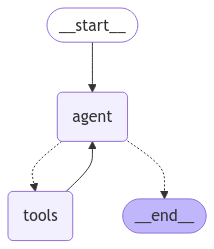

In [47]:
from langchain_groq import ChatGroq

model = ChatGroq(model="llama3-70b-8192", temperature=0)

from typing import Literal

from langchain_core.tools import tool

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


@tool
def definition_metadata(definition_metadata: dict) -> str:
    """
    Extracts the metadata of an XML file.
    """

    namespace = settings.DB_CONFIG.NAMESPACES[definition_metadata['dataset']]

    file_path = utils.definition_obj_to_path(definition_metadata)
    def_n = definition_metadata['def_n']
    try:
        # Parse the XML file
        tree = ET.parse(Path(settings.DB_CONFIG.XML_DATA_DIR) / file_path)
        root = tree.getroot()

        # Find the element with the specified defines attribute
        res = root.find(f".//akn:*[@defines='{def_n}']", namespace)
        if res is not None:
            return ''.join(res.itertext()).strip()
        # Return None if no match is found
        return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None


tools = [get_document_year]

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


In [49]:
inp = """
[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the transport of passengers, a bus or coach;',
  'metadata': {'id': 9568,
   'dataset': 'EurLex',
   'document_id': '32019R0501.xml',
   'def_n': '#def_1',
   'references': ['/akn/eu/act/directive/ep/2006/1/',
    '/akn/eu/act/directive/ep/2006/1/',
    '/akn/eu/documentCollection/L/gu/2006-02-04/033/!main#eop_82']}},
 {'definition_text': "autoveicolo della categoria Euro 0, Euro I, Euro II, Euro III, Euro IV, Euro V, EEV: un autoveicolo conforme ai limiti di emissione indicati nell'allegato I;",
  'metadata': {'id': 9830,
   'dataset': 'Normattiva',
   'document_id': '20100209_010G0021_VIGENZA_20200715.xml',
   'def_n': '#def_9',
   'references': []}},
 {'definition_text': "ACI: l'Automobile Club d'Italia;",
  'metadata': {'id': 12009,
   'dataset': 'Normattiva',
   'document_id': '20221121_22G00188_ORIGINALE.xml',
   'def_n': '#def_8',
   'references': []}}]


which one of these definitions is from 2015?

"""

inputs = {"messages": [("user", inp)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================


[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for th

In [3]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from LegalDefAgent.src.settings import settings
from LegalDefAgent.src import utils
import xml.etree.ElementTree as ET
from pathlib import Path

model = ChatGroq(model="llama3-8b-8192", temperature=0)



class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    answer_def: dict = picked_def


@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"


@tool
def extract_definition_metadata(definition_metadata: dict) -> str:
    """
    Extracts the metadata of an XML file.
    """

    namespace = settings.DB_CONFIG.NAMESPACES[definition_metadata['dataset']]

    file_path = utils.definition_obj_to_path(definition_metadata)
    def_n = definition_metadata['def_n']
    try:
        # Parse the XML file
        tree = ET.parse(Path(settings.DB_CONFIG.XML_DATA_DIR) / file_path)
        root = tree.getroot()

        # Find the element with the specified defines attribute
        res = root.find(f".//akn:*[@defines='{def_n}']", namespace)
        if res is not None:
            return ''.join(res.itertext()).strip()
        # Return None if no match is found
        return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None

tools = [extract_definition_metadata]

model = model.bind_tools(tools)

import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

system_prompt = SystemMessagePromptTemplate(
        template="""
            You are a legal expert and your task is to answer a user's query about a legal definition. \n
            You are provided with a list of automatically retrieved definitions and you need to pick the one that best answers the user's query. \n
            Here are the retrieved definitions: {context}
            Here is the user's query: {question}
            You have a number of tools at your disposal to help you with this task, including the ability to extract metadata from the definitions if needed. \n
            Here are some info to base your decision on:
                * EurLex is the European Union's legal database.
                * Normattiva is the Italian legal database.
                * PDL is the Italian Parliament's legal database.
                * If the user's query is in Italian or asks about the Italian legislation, Normattiva and PDL definitions should preferred.
                * If the user asks about the European legislation, EurLex definitions should preferred.
            """,
    partial_variables={"context": str(defs), "question": "What is the definition of 'vehicle'?"}
)

# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible

    response = model.invoke(system_prompt, config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"
    
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

NameError: name 'picked_def' is not defined

In [ ]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

NameError: name 'state' is not defined

---

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = model

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[extract_definition_metadata],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [5]:
import os
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.retrievers import ParentDocumentRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.storage._lc_store import create_kv_docstore
from langchain.storage import LocalFileStore
from langchain.agents import Tool
from langchain.document_loaders import TextLoader
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor, create_react_agent
from langchain import hub
from langchain.pydantic_v1 import BaseModel, Field
from langchain.agents import create_openai_tools_agent
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.pydantic_v1 import BaseModel, Field
from langchain.agents import tool
import numpy as np
import langchain
import openai

prompt = hub.pull("hwchase17/react")
print(prompt.template)

model = ChatGroq(model="llama3-70b-8192", temperature=0)


from langchain.tools.retriever import create_retriever_tool
from LegalDefAgent.src.retriever import vector_store

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_definitions",
    "Search and return legal definitions of terms from a vector store.",
)


react_agent = create_react_agent(model, [retriever_tool], prompt)
agent_executor = AgentExecutor(
agent=react_agent,
tools=[retriever_tool],
verbose=True,
handle_parsing_errors=True,
max_iterations = 2
)


query = "how are you?"
agent_executor.invoke({"input": query})

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


> Entering new AgentExecutor chain...
Thought: I need to provide a response to the question "how are you?" which is a casual greeting. I don't think I can retrieve a legal definition for this question, so I'll just respond in a friendly manner.

Final Answer: I'm doing well, thanks for asking!

> Finished chain.


{'input': 'how are you?', 'output': "I'm doing well, thanks for asking!"}

In [5]:
defs

[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the tra

In [10]:
get_document_date.name

'get_document_date'

In [ ]:
## grader test
from langchain_groq import ChatGroq
from LegalDefAgent.src.schema.grader import DefinitionRelevance
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain.agents.agent import AgentExecutor
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langgraph.prebuilt import create_react_agent



class DefinitionResponse(BaseModel):
    """Respond to the user with this"""

    definition: str = Field(description="The text of the definition")
    dataset: str = Field(
        description="The dataset the definition is from"
    )
    def_n: str = Field(description="The number of the definition")

class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: DefinitionResponse


@tool
def get_document_date(definition_metadata: dict) -> str:
    """
    Extracts the date from the document id of a definition.
    """

    namespace = settings.DB_CONFIG.NAMESPACES[definition_metadata['dataset']]

    file_path = utils.definition_obj_to_path(definition_metadata)
    try:
        # Parse the XML file
        tree = ET.parse(Path(settings.DB_CONFIG.XML_DATA_DIR) / file_path)
        root = tree.getroot()

        # Find the element with the specified defines attribute
        frbr_expression = root.find(f".//akn:FRBRExpression", namespace)
        if frbr_expression is not None:
            frbr_date = frbr_expression.find(".//akn:FRBRdate", namespace)
            if frbr_date is not None:
                return frbr_date.attrib['date']
        # Return None if no match is found
        return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None



# LLM with function call
model = ChatGroq(model="llama3-70b-8192", temperature=0)
#model_with_tools = model.bind_tools(tools)
#structured_llm_grader = model.bind_tools(tools)#.with_structured_output(GradeDefinitions)
#model_with_structured_output = model.with_structured_output(DefinitionResponse)


retrieved_defs = [{"definition_text":"dog: means a kept animal of the Canis lupus species;","metadata":{"id":4284,"dataset":"EurLex","document_id":"32020R0689.xml","def_n":"#def_10","references":[]}},{"definition_text":"dog: means a kept animal of the Canis lupus species;","metadata":{"id":2307,"dataset":"EurLex","document_id":"32019R2035.xml","def_n":"#def_1","references":[]}},{"definition_text":"dog: means a kept animal of the Canis lupus species;","metadata":{"id":3843,"dataset":"EurLex","document_id":"32013R0576.xml","def_n":"#def_9","references":[]}}]


prompt = PromptTemplate(
    template="""
    You are a legal expert with the task of assessing whether a retrieved legal definition is the correct one answer to a user's question.\n 
    Give a binary score 'yes' or 'no' score to indicate whether the definition is relevant to the question. \n
    You have at your disposal a number of tools that you can use in case you a specific piece of information is required to decide on the relevance of the definitions. Use them only in the strict cases in which you need those information.\n
    Here is the user question: {question}
    Here is the retrieved definition: {definition}
    Here are the tools you can use: {tools}
    """,
    input_variables=["question", "definition", "tools"],
    )

tools = [get_document_date]
tools_names = [tool.name for tool in tools]

react_agent = create_react_agent(model, tools=tools, state_modifier=prompt.)

options = tools_names + ["FINISH"]

retrieval_grader = react_agent
question = "what is the definition of 'dog' in 2015?"
#print(retrieval_grader.invoke({"question": question, "document": defs[0]}))

print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
# Score each doc
filtered_docs = []
web_search = "No"
for d in retrieved_defs:
    print(d)
    score = react_agent.invoke({"messages": [("human", question)], "question": question, "definition": d, "tools": tools_names})
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        filtered_docs.append(d)
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        web_search = "Yes"
        continue


---CHECK DOCUMENT RELEVANCE TO QUESTION---
{'definition_text': 'dog: means a kept animal of the Canis lupus species;', 'metadata': {'id': 4284, 'dataset': 'EurLex', 'document_id': '32020R0689.xml', 'def_n': '#def_10', 'references': []}}


KeyError: "Input to PromptTemplate is missing variables {'question', 'definition', 'tools'}.  Expected: ['definition', 'question', 'tools'] Received: ['messages', 'is_last_step', 'remaining_steps']\nNote: if you intended {question} to be part of the string and not a variable, please escape it with double curly braces like: '{{question}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [19]:
prompt.invoke('', question=question, definition='ff', tools=tools_names)

TypeError: Expected mapping type as input to PromptTemplate. Received <class 'str'>.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT 

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b

class Add(BaseModel):
    """Add two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

model = ChatOpenAI(model="gpt-4o-mini")
tools = [Add]  # `add` works just as well
agent = create_react_agent(model, tools)  # note that there is no 3rd argument here

agent.invoke({"messages": [("human", "what's 2 + 2")]})


/home/leo/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


{'messages': [HumanMessage(content="what's 2 + 2", additional_kwargs={}, response_metadata={}, id='5242375d-7be2-41fc-8252-aa35d85aff16'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c5Rz9tz3F3kAeJayh57uTWzg', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'Add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 52, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6d1321e3-8c13-4ff0-935a-64332abdd25c-0', tool_calls=[{'name': 'Add', 'args': {'a': 2, 'b': 2}, 'id': 'call_c5Rz9tz3F3kAeJayh57uTWzg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 17, 'total

In [30]:
question = "What is the definition of 'dog' in 2015?"
docs = retriever.invoke(question)
defs

Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)


[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the tra

In [98]:
from typing import Annotated, Literal, TypedDict

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from LegalDefAgent.src.settings import settings
import xml.etree.ElementTree as ET
from pathlib import Path


class State(TypedDict): # Messages have the type "list". The 'add_messages' function # in the annotation defines how this state key should be updated # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    retrieved_definitions: list = docs

# Define the tools for the agent to use
@tool
def search(query: str) -> str:
    """Call to surf the web.""" # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

@tool
def get_document_date(dataset: str, document_id: str) -> str:
    """
    Extracts the date from the document id of a definition.
    Use this tool when the date is needed.
    """

    namespace = settings.DB_CONFIG.NAMESPACES[dataset]

    import os
    file_path = os.path.join(dataset, document_id)
    try:
        # Parse the XML file
        tree = ET.parse(Path(settings.DB_CONFIG.XML_DATA_DIR) / file_path)
        root = tree.getroot()

        # Find the element with the specified defines attribute
        frbr_expression = root.find(f".//akn:FRBRExpression", namespace)
        if frbr_expression is not None:
            frbr_date = frbr_expression.find(".//akn:FRBRdate", namespace)
            if frbr_date is not None:
                return frbr_date.attrib['date']
        # Return None if no match is found
        return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None

tools = [get_document_date]
tool_node = ToolNode(tools)
model = ChatGroq(model="llama3-70b-8192", temperature=0)
model = model.bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1] # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools" # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model

def call_model(state: State):
    messages = state['messages']
    response = model.invoke(messages) # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as 'agent'
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges( # First, we define the start node. We use 'agent'. # This means these are the edges taken after the 'agent' node is called.
    "agent", # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from 'tools' to 'agent'.
# This means that after 'tools' is called, 'agent' node is called next.
workflow.add_edge("tools", 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile()

In [62]:
defs

[{'definition_text': 'Vehicle carrier: means a multi-deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks;',
  'metadata': {'id': 5907,
   'dataset': 'EurLex',
   'document_id': '32016R1928.xml',
   'def_n': '#def_8',
   'references': []}},
 {'definition_text': 'vehicle: means, in respect of carriage of goods, a motor vehicle registered in the United Kingdom, or a coupled combination of vehicles the motor vehicle of which at least is registered in the United Kingdom, used exclusively for the carriage of goods, either owned by the undertaking, having been bought by it on deferred terms or having been hired, provided that, in the latter case, it meets the conditions set out in Directive 2006/1/EC of the European Parliament and of the Council Directive 2006/1/EC of the European Parliament and of the Council of 18 January 2006 on the use of vehicles hired without drivers for the carriage of goods by road ( OJ L 33, 4.2.2006, p. 82 ). and in respect of the tra

In [78]:
def docs_to_json(docs):
    return [{'definition_text': doc.to_json().get('kwargs').get('page_content'), 'metadata': doc.to_json().get('kwargs').get('metadata')} for doc in docs]



In [101]:
query = 'verro'

docs = docs_to_json(retriever.invoke(query))
print(docs)

info = """
* The EurLex dataset contains legal definitions from the European Union.
* The Normattiva dataset contains legal definitions from Italy.
* The PDL dataset contains legal definitions from the Italian Parliament.
"""

tools_desc = """
* Use the 'get_document_date' tool to extract the date from the document id of a definition if required to answer the user's query.
"""
inputs = {"messages": [
    ("system", f"You are a legal expert. Your job is to analyze the retrieved definitions and choose the one that better answers the user's query.\n\nYou should always think about what to do, do not use any tool if it is not needed. \n\nThink very deeply about whether the definition falls within the context of the user's query, taking into consideration variables such as Jurisdiction or date.\n\n You have at your disposal the following tools: {tools_desc}\n\nYou should use the following info to pick the best definition: {info}.\n\nIn case you don't find the an appropriate definition, you should output 'generate'. The retrieved definitions are: {docs}"),
    ("user", f"Quale è la definizione di '{query}'?")
    ]}
app.invoke(inputs)

Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)


[{'definition_text': "verro: un suino di sesso maschile che ha raggiunto la puberta' ed e' destinato alla riproduzione;", 'metadata': {'dataset': 'Normattiva', 'def_n': '#def_2', 'document_id': '20110802_011G0164_ORIGINALE.xml', 'id': 12896, 'references': []}}, {'definition_text': 'ro-ro passenger ship: and carrying more than 12 passengers;', 'metadata': {'dataset': 'EurLex', 'def_n': '#def_1', 'document_id': '32017L2110.xml', 'id': 5952, 'references': []}}, {'definition_text': 'varnish: means a transparent coating;', 'metadata': {'dataset': 'EurLex', 'def_n': '#def_57', 'document_id': '32010L0075.xml', 'id': 4529, 'references': []}}, {'definition_text': 'verification: means the process of comparing sets of data to establish the validity of a claimed identity (one-to-one check);', 'metadata': {'dataset': 'EurLex', 'def_n': '#def_5', 'document_id': '32019R0817.xml', 'id': 8869, 'references': []}}]


{'messages': [SystemMessage(content='You are a legal expert. Your job is to analyze the retrieved definitions and choose the one that better answers the user\'s query.\n\nYou should always think about what to do, do not use any tool if it is not needed. \n\nThink very deeply about whether the definition falls within the context of the user\'s query, taking into consideration variables such as Jurisdiction or date.\n\n You have at your disposal the following tools: \n* Use the \'get_document_date\' tool to extract the date from the document id of a definition if required to answer the user\'s query.\n\n\nYou should use the following info to pick the best definition: \n* The EurLex dataset contains legal definitions from the European Union.\n* The Normattiva dataset contains legal definitions from Italy.\n* The PDL dataset contains legal definitions from the Italian Parliament.\n.\n\nIn case you don\'t find the an appropriate definition, you should output \'generate\'. The retrieved defi